In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

file_path =  r'C:\Users\Thalyson\Desktop\movies.csv'
df = pd.read_csv(file_path)
df.shape
df.info()
     

In [ ]:
# Colunas a remover
colunas_inuteis = [
    'id', 'title', 'overview', 'production_companies', 'status',
    'tagline', 'credits', 'poster_path', 'backdrop_path', 'recommendations'
]

# Drop no DataFrame
df = df.drop(columns=colunas_inuteis)

In [ ]:
df['budget'] = df['budget'].replace(0, 1)
df['revenue'] = df['revenue'].replace(0, 1)

# Aplica log natural
df['budget_log'] = np.log(df['budget'])
df['revenue_log'] = np.log(df['revenue'])

c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df.drop(columns=['budget', 'revenue'])

,genres,original_language,popularity,release_date,runtime,vote_average,vote_count,keywords,budget_log,revenue_log
0,Action-Science Fiction-Horror,en,8763.998,2023-08-02,116.0,7.079,1365.0,based on novel or book-sequel-kaiju,18.675323,19.679302
1,Horror-Mystery-Thriller,en,5953.227,2023-04-05,103.0,7.433,545.0,spain-rome italy-vatican-pope-pig-possession-c...,16.705882,18.000241
2,Action-Comedy-Science Fiction,en,5410.496,2024-07-24,128.0,7.765,3749.0,hero-superhero-anti hero-mutant-breaking the f...,19.113828,21.005725
3,Action-Adventure-Science Fiction,en,5409.104,2023-06-06,127.0,7.340,1007.0,peru-alien-end of the world-based on cartoon-b...,19.113828,19.824435
4,Science Fiction-Adventure,en,4742.163,2024-02-27,167.0,8.300,2770.0,epic-based on novel or book-fight-sandstorm-sa...,19.062535,20.343196
...,...,...,...,...,...,...,...,...,...,...
722312,Documentary-History-War,en,0.001,2020-01-01,120.0,0.000,0.0,NaN,0.000000,0.000000
722313,Comedy-Romance,en,0.001,1930-03-02,63.0,0.000,0.0,lost film,0.000000,0.000000
722314,Animation-Drama-Mystery-Adventure,ko,0.001,2024-09-27,97.0,0.000,0.0,bullying-slice of life-school life,0.000000,0.000000
722315,NaN,en,0.001,2005-04-19,120.0,0.000,0.0,NaN,0.000000,0.000000


<Axes: >

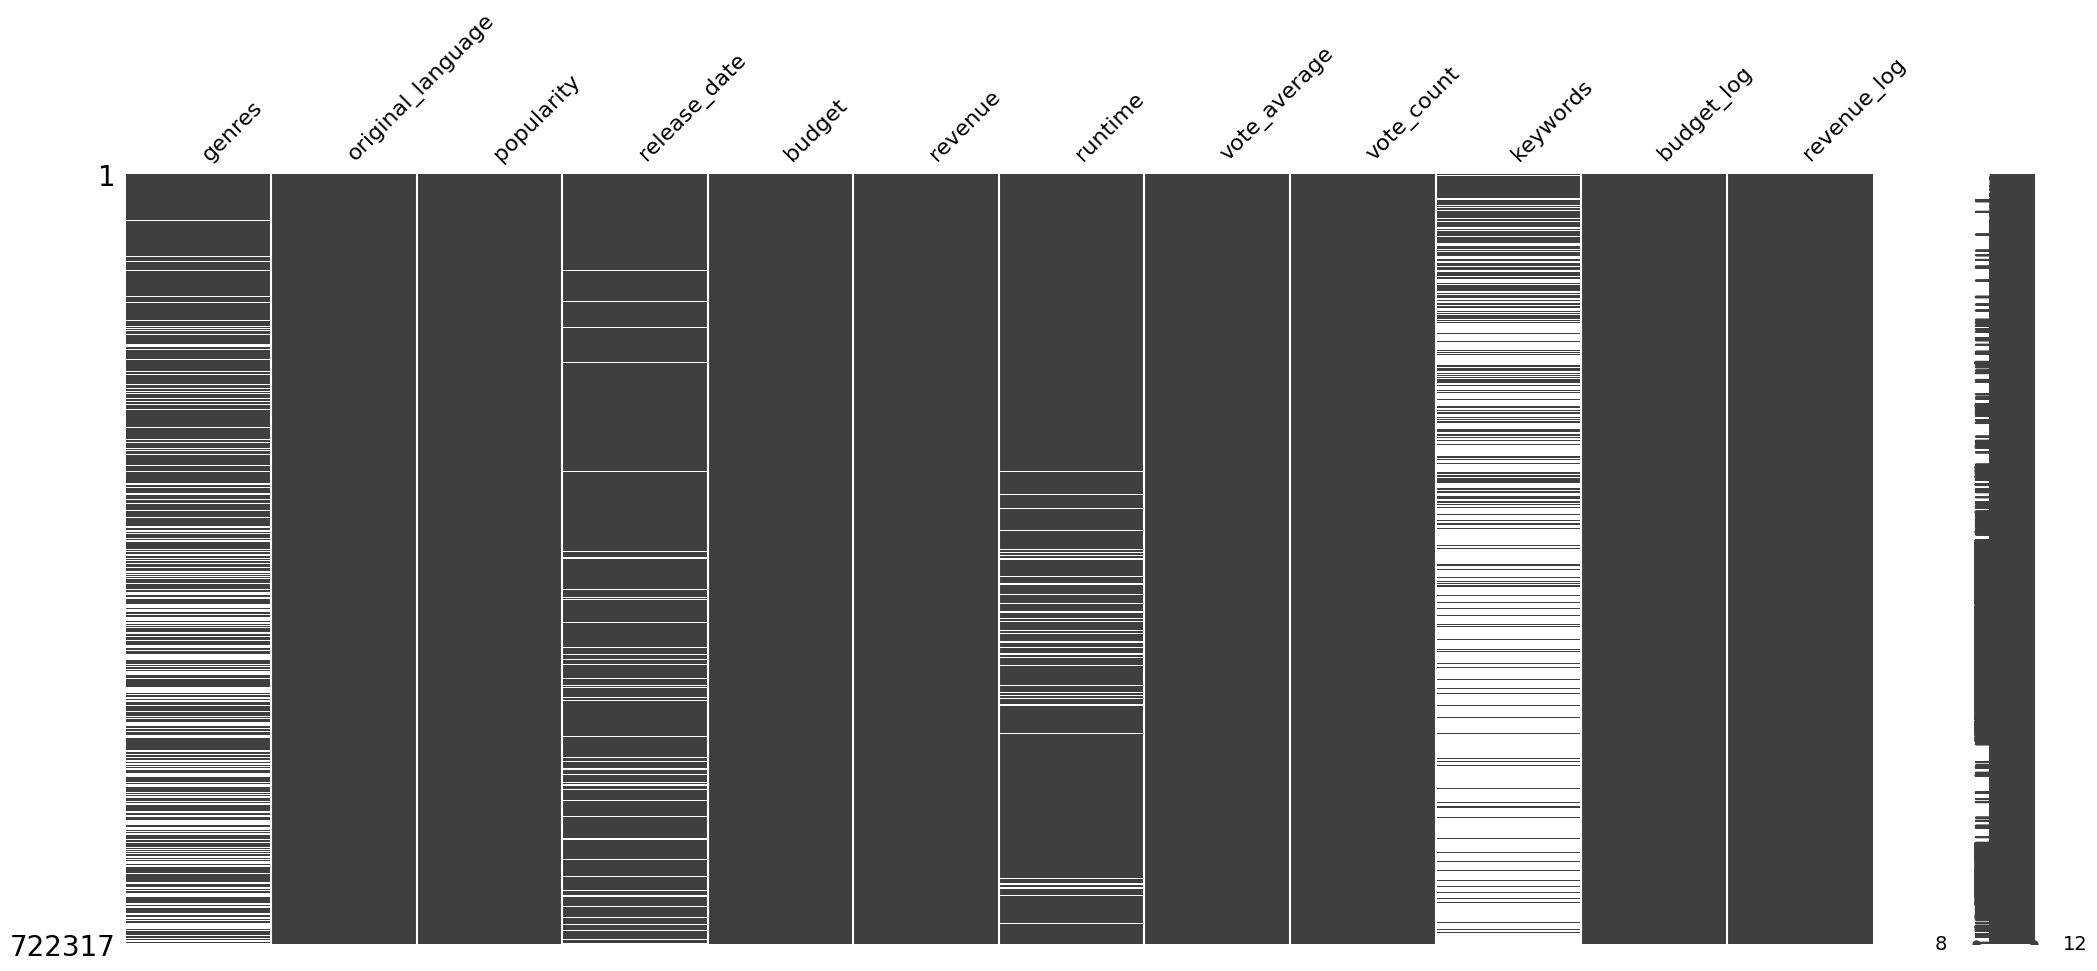

In [ ]:
msno.matrix(df)

In [ ]:
# Cria colunas de ano e mês
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

In [ ]:
# Preencher valores nulos de runtime com a mediana
median_runtime = df['runtime'].median()
df['runtime'] = df['runtime'].fillna(median_runtime)

# Converter para inteiro
df['runtime'] = df['runtime'].astype(int)
df['vote_count'] = df['vote_count'].astype(int)

In [ ]:

# 1. Ajusta a coluna 'genres' para lista (supondo que os gêneros estejam separados por hífen '-')
df['genres'] = df['genres'].fillna('')  # evita erro com NaN
df['genres'] = df['genres'].apply(lambda x: x.split('-'))

# 2. Conta frequência de cada gênero em todas as listas
contagem = Counter([genero for sublist in df['genres'] for genero in sublist if genero])

# 3. Define gêneros raros com contagem menor que 900
generos_raros = [g for g, count in contagem.items() if count < 900]

# 4. Substitui gêneros raros por 'Outros'
def substituir_raros(lista):
    return [g if g not in generos_raros else 'Outros' for g in lista]

df['genres'] = df['genres'].apply(substituir_raros)

# 5. Reconta e exibe gêneros atualizados
contagem_atualizada = Counter([genero for lista in df['genres'] for genero in lista if genero])
genero_series = pd.Series(contagem_atualizada).sort_values(ascending=False)
print(genero_series)
print(f"\nTotal de gêneros únicos após substituição: {len(genero_series)}")

# 6. Agora transforme a lista de gêneros em string para aplicar CountVectorizer ou get_dummies:
df['genres_str'] = df['genres'].apply(lambda x: ' '.join(x))

# 7. Aplicar CountVectorizer para criar features numéricas, mantendo a matriz esparsa e controlando memória:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_genres = vectorizer.fit_transform(df['genres_str'])

# 8. Criar DataFrame esparso e juntar com df
df_genres = pd.DataFrame.sparse.from_spmatrix(X_genres, columns=vectorizer.get_feature_names_out())
df = pd.concat([df, df_genres], axis=1)

# 9. Remover as colunas antigas que não vamos mais usar
df.drop(columns=['genres', 'genres_str'], inplace=True)

Drama              176534
Documentary        116948
Comedy             110461
Animation           42145
Romance             41217
Thriller            36900
Horror              36355
Action              36177
Music               36005
Crime               26992
Family              22793
Adventure           19547
TV Movie            19007
Fantasy             16906
Science Fiction     16613
Mystery             15240
History             13384
War                  8941
Western              7933
dtype: int64

Total de gêneros únicos após substituição: 19


In [ ]:
idioma_para_continente = {
    # América do Norte
    'en': 'America_do_Norte',

    # Ásia
    'ko': 'Asia',
    'cn': 'Asia', # Chinês (Simplificado/Mandarin)
    'hi': 'Asia', # Hindi
    'ja': 'Asia', # Japonês
    'zh': 'Asia', # Chinês (Genérico/Variedades)
    'te': 'Asia', # Telugu
    'ar': 'Asia', # Árabe (Também África)
    'ml': 'Asia', # Malayalam
    'kn': 'Asia', # Kannada
    'ta': 'Asia', # Tamil
    'km': 'Asia', # Khmer
    'he': 'Asia', # Hebraico
    'bn': 'Asia', # Bengali
    'ms': 'Asia', # Malaio
    'bo': 'Asia', # Tibetano
    'kk': 'Asia', # Cazaque (Também Europa)
    'ka': 'Asia', # Georgiano (Também Europa)
    'ku': 'Asia', # Curdo (Também Europa)
    'ur': 'Asia', # Urdu
    'ps': 'Asia', # Pashto
    'mr': 'Asia', # Marathi
    'lo': 'Asia', # Laosiano
    'ne': 'Asia', # Nepalês


    # Europa
    'es': 'Europa', # Espanhol (Também Américas)
    'no': 'Europa', # Norueguês
    'fi': 'Europa', # Finlandês
    'ru': 'Europa', # Russo (Também Ásia)
    'uk': 'Europa', # Ucraniano
    'nl': 'Europa', # Holandês
    'it': 'Europa', # Italiano
    'fr': 'Europa', # Francês (Também Américas, África)
    'pl': 'Europa', # Polonês
    'pt': 'Europa', # Português (Também Américas, África)
    'de': 'Europa', # Alemão
    'ro': 'Europa', # Romeno
    'sr': 'Europa', # Sérvio
    'sv': 'Europa', # Sueco
    'gl': 'Europa', # Galego
    'tr': 'Europa', # Turco (Também Ásia)
    'cs': 'Europa', # Tcheco
    'el': 'Europa', # Grego
    'ga': 'Europa', # Irlandês
    'mk': 'Europa', # Macedônio
    'sh': 'Europa', # Sérvio-Croata
    'hu': 'Europa', # Húngaro
    'eu': 'Europa', # Basco
    'lv': 'Europa', # Letão
    'sk': 'Europa', # Eslovaco
    'et': 'Europa', # Estoniano
    'hy': 'Europa', # Armênio (Também Ásia)
    'sq': 'Europa', # Albanês
    'se': 'Europa', # Sami Setentrional
    'sl': 'Europa', # Esloveno
    'cy': 'Europa', # Galês
    'lt': 'Europa', # Lituano
    'hr': 'Europa', # Croata
    'bg': 'Europa', # Búlgaro
    'yi': 'Europa', # Iídiche
    'eo': 'Europa', # Esperanto
    'nb': 'Europa', # Bokmål Norueguês


    # África
    'sw': 'Africa', # Suaíli
    'af': 'Africa', # Africâner
    'am': 'Africa', # Amárico
    'zu': 'Africa', # Zulu
    'xh': 'Africa', # Xhosa
    'wo': 'Africa', # Uolofe
    'bm': 'Africa', # Bambara


    # América do Sul
    'qu': 'America_do_Sul', # Quechua
    'ay': 'America_do_Sul', # Aimará


    # Oceania
    'mi': 'Oceania', # Maori


    # Outros / Desconhecido / Códigos Especiais
    'id': 'Asia',   # Indonésio (Geralmente Ásia, mas para simplificar, pode agrupar)
    'is': 'Europa',   # Islandês (Europa, mas pode ser um grupo separado se for muito raro)
    'tl': 'Asia',   # Tagalo (Filipino) (Ásia, mas pode agrupar)
    'dz': 'Asia',   # Dzongkha (Ásia, Butão)
    'xx': 'Outros',   # Sem linguagem / Linguagem desconhecida (Código especial)
    'la': 'Outros',   # Latim (Histórico)
    'vi': 'Asia',   # Vietnamita (Ásia, mas pode agrupar)
    'bs': 'Europa',   # Bósnio (Europa, mas pode agrupar)
    'iu': 'America_do_Norte',   # Inuktitut (América do Norte, Ártico)
    'pa': 'Asia',   # Punjabi (Ásia, mas pode agrupar)
    'th': 'Asia', # Tailandês (Ásia, mas para manter consistência com Ásia acima)

    # Adicionar os idiomas restantes que não foram listados explicitamente acima
    # ...
}

# Mapear a coluna original_language para continentes usando o dicionário idioma_para_continente
df['continent'] = df['original_language'].map(idioma_para_continente)

# Preencher valores faltantes com 'Outros'
df['continent'] = df['continent'].fillna('Outros')

# Criar colunas dummies para os continentes
df_continentes_encoded = pd.get_dummies(df['continent'], prefix='continent')

# Concatenar as novas colunas ao df original
df = pd.concat([df, df_continentes_encoded], axis=1)

# Opcional: remover a coluna 'continent' original se não precisar mais dela
# df = df.drop(columns=['continent'])
df.head()

,original_language,popularity,release_date,budget,revenue,runtime,vote_average,vote_count,keywords,budget_log,...,war,western,continent,continent_Africa,continent_America_do_Norte,continent_America_do_Sul,continent_Asia,continent_Europa,continent_Oceania,continent_Outros
0,en,8763.998,2023-08-02,129000000.0,3.520565e+08,116,7.079,1365,based on novel or book-sequel-kaiju,18.675323,...,0,0,America_do_Norte,False,True,False,False,False,False,False
1,en,5953.227,2023-04-05,18000000.0,6.567582e+07,103,7.433,545,spain-rome italy-vatican-pope-pig-possession-c...,16.705882,...,0,0,America_do_Norte,False,True,False,False,False,False,False
2,en,5410.496,2024-07-24,200000000.0,1.326387e+09,128,7.765,3749,hero-superhero-anti hero-mutant-breaking the f...,19.113828,...,0,0,America_do_Norte,False,True,False,False,False,False,False
3,en,5409.104,2023-06-06,200000000.0,4.070455e+08,127,7.340,1007,peru-alien-end of the world-based on cartoon-b...,19.113828,...,0,0,America_do_Norte,False,True,False,False,False,False,False
4,en,4742.163,2024-02-27,190000000.0,6.838137e+08,167,8.300,2770,epic-based on novel or book-fight-sandstorm-sa...,19.062535,...,0,0,America_do_Norte,False,True,False,False,False,False,False


In [ ]:
if 'original_language' in df.columns:
    df = df.drop('original_language', axis=1)
if 'continent' in df.columns:
    df = df.drop('continent', axis=1)


df= df.drop(columns=["release_date", "keywords"])
df= df.dropna(subset=['release_year', 'release_month', 'revenue_log'])

print(df.isnull().sum())
print(df.shape) 


popularity                        0
budget                            0
revenue                           0
runtime                           0
vote_average                      0
vote_count                        0
budget_log                        0
revenue_log                       0
release_year                      0
release_month                     0
action                        False
adventure                     False
animation                     False
comedy                        False
crime                         False
documentary                   False
drama                         False
family                        False
fantasy                       False
fiction                       False
history                       False
horror                        False
movie                         False
music                         False
mystery                       False
romance                       False
science                       False
thriller                    

C:\Users\thalyson\AppData\Local\Temp\ipykernel_19700\3549145841.py:10: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  print(df.isnull().sum())


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670767 entries, 0 to 722316
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype           
---  ------                      --------------   -----           
 0   popularity                  670767 non-null  float64         
 1   budget                      670767 non-null  float64         
 2   revenue                     670767 non-null  float64         
 3   runtime                     670767 non-null  int64           
 4   vote_average                670767 non-null  float64         
 5   vote_count                  670767 non-null  int64           
 6   budget_log                  670767 non-null  float64         
 7   revenue_log                 670767 non-null  float64         
 8   release_year                670767 non-null  float64         
 9   release_month               670767 non-null  float64         
 10  action                      1 non-null       Sparse[int64, 0]
 11  adventure         

C:\Users\thalyson\AppData\Local\Temp\ipykernel_19700\3771845804.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df.info()


In [ ]:


# Define as colunas numéricas que queremos padronizar
colunas_numericas = [
    'popularity',
    'vote_count',
    'vote_average',
    'runtime',
    'release_year',
    'release_month',
    'budget_log',
    'revenue_log'
]

# Cria o objeto do StandardScaler
scaler = StandardScaler()

# Aplica a padronização nas colunas selecionadas
df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

# Exibe as estatísticas para verificar a padronização
print(df[colunas_numericas].describe())


          popularity    vote_count  vote_average       runtime  release_year  \
count  670767.000000  6.707670e+05  6.707670e+05  6.707670e+05  6.707670e+05   
mean        0.000000  5.423610e-18  8.677776e-17  2.169444e-17  2.511132e-15   
std         1.000001  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min        -0.081884 -7.453032e-02 -8.093990e-01 -5.300403e-01 -4.408685e+00   
25%        -0.057475 -7.453032e-02 -8.093990e-01 -4.619214e-01 -4.526086e-01   
50%        -0.057312 -7.453032e-02 -8.093990e-01 -4.347667e-02  4.464996e-01   
75%        -0.026272 -6.966947e-02  1.004463e+00  3.457742e-01  7.342142e-01   
max       356.447858  8.464282e+01  2.317950e+00  4.998520e+02  1.885073e+00   

       release_month    budget_log   revenue_log  
count   6.707670e+05  6.707670e+05  6.707670e+05  
mean    3.254166e-17  5.423610e-17 -1.084722e-17  
std     1.000001e+00  1.000001e+00  1.000001e+00  
min    -1.283130e+00 -2.149408e-01 -1.537590e-01  
25%    -1.022219e+00 -2.

c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\thalyson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\va

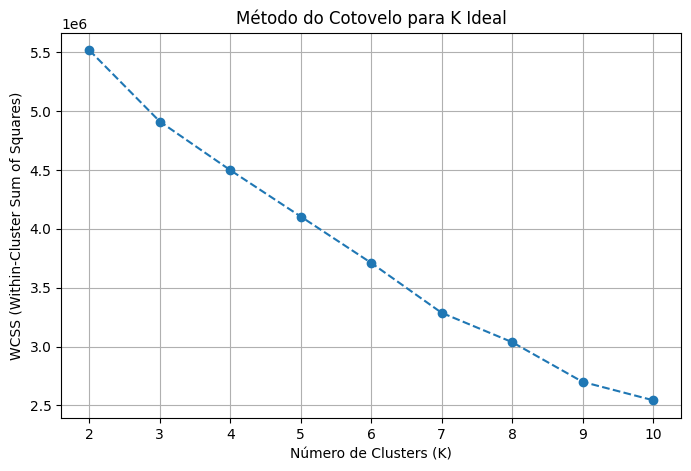

In [ ]:

# Colunas numéricas padronizadas
colunas_numericas = [
    'popularity',
    'vote_count',
    'vote_average',
    'runtime',
    'release_year',
    'release_month',
    'budget_log',
    'revenue_log'
]

# Colunas de gênero: nomes típicos de gêneros
generos = [
    'action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
    'drama', 'family', 'fantasy', 'fiction', 'history', 'horror', 'movie',
    'music', 'mystery', 'others', 'romance', 'science', 'thriller',
    'tv', 'war', 'western'
]
colunas_generos = [col for col in df.columns if col in generos]

# Colunas de continente: prefixadas com 'continent_'
colunas_continentes = [col for col in df.columns if col.startswith('continent_')]

# Juntar tudo
features = colunas_numericas + colunas_generos + colunas_continentes
X = df[features].copy()


inertias = []
range_n_clusters = range(2, 11)

# Lista para armazenar o WCSS (inertia)
wcss = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)  # X com suas features (numéricas + dummies)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo para K Ideal')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Supondo que X já está pronto (denso, numérico + dummies)

n_clusters = 6

# Treinar o KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Calcular os valores de silhueta para cada amostra
silhouette_vals = silhouette_samples(X, cluster_labels)

# Calcular o score médio geral
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score médio para {n_clusters} clusters: {silhouette_avg:.4f}")

# Plotar gráfico de silhueta
plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(n_clusters):
    # Valores de silhueta para o cluster i, ordenados
    ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label do cluster no meio do gráfico
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 para espaço entre os clusters

plt.title(f"Gráfico de Silhueta para {n_clusters} clusters")
plt.xlabel("Valor de Silhueta")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])  # Esconde os ticks do eixo y para melhor visualização
plt.show()